In [20]:
# conda install xarray

In [21]:
import pickle
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

from IPython.display import HTML
import jax
import matplotlib
from ipywidgets import widgets
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray
import matplotlib.pyplot as plt


In [22]:
# mesh坐标
with open('../graphcast-data/_mesh_nodes_lat.pkl', 'rb') as f:
    _mesh_nodes_lat = pickle.load(f)
with open('../graphcast-data/_mesh_nodes_lon.pkl', 'rb') as f:
    _mesh_nodes_lon = pickle.load(f)
# grid坐标
# with open('../graphcast-data/_grid_lat.pkl', 'rb') as f:
#     _grid_lat = pickle.load(f)
# with open('../graphcast-data/_grid_lon.pkl', 'rb') as f:
#     _grid_lon = pickle.load(f)

with open('../graphcast-data/eval_inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open('../graphcast-data/eval_forcings.pkl', 'rb') as f:
    forcings = pickle.load(f)
with open('../graphcast-data/eval_targets.pkl', 'rb') as f:
    eval_targets = pickle.load(f)
with open('../graphcast-data/predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)
with open('../graphcast-data/grid_node_features.pkl', 'rb') as f:
    grid_node_features = pickle.load(f)
with open('../graphcast-data/latent_mesh_nodes.pkl', 'rb') as f:
    latent_mesh_nodes = pickle.load(f)
# with open('../graphcast-data/output_grid_nodes.pkl', 'rb') as f:
#     output_grid_nodes = pickle.load(f)


# 处理grid坐标
_grid_lat = predictions.lat.values
_grid_lon = predictions.lon.values
grid_lat, grid_lon = np.meshgrid(_grid_lat, _grid_lon)
flat_grid_lat = grid_lat.ravel()
flat_grid_lon = grid_lon.ravel()
print((flat_grid_lon),len(flat_grid_lat))


# for var_name, var in inputs.data_vars.items():
#     print(f"变量名: {var_name}, 形状: {var.shape}")
# print("forcings")
# for var_name, var in forcings.data_vars.items():
#     print(f"变量名: {var_name}, 形状: {var.shape}")
# channels 471 是怎么计算出来的？
# 37 levels * 2 time * 18 variables = 1332
# 466(每个变量的channels总和) + 5
# ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'day_progress_cos', 'day_progress_sin', 'geopotential', 'geopotential_at_surface', 'land_sea_mask', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'toa_incident_solar_radiation', 'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 'year_progress_cos', 'year_progress_sin']
# day_progress_cos, day_progress_sin, toa_incident_solar_radiation, year_progress_cos, year_progress_sin
# grid_node_features.shape




[  0.     0.     0.   ... 359.75 359.75 359.75] 1038240


In [23]:
latent_mesh_nodes.shape # (1038240, 1, 471)
# print(_grid_lat.shape)
# print(_grid_lon.shape)


# print(flat_grid_lon)
# print(flat_grid_lat)

(40962, 1, 512)

# Embedding

##### 全量的latent_mesh_nodes

In [ ]:
# 可视化
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 将数据展平为 (40962, 512)，因为 t-SNE 需要二维输入
latent_mesh_nodes_new = latent_mesh_nodes.reshape(latent_mesh_nodes.shape[0], -1)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
latent_2d = tsne.fit_transform(latent_mesh_nodes_new)

# 可视化降维后的数据
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.5, c=np.arange(latent_2d.shape[0]))
plt.title("t-SNE Visualization of latent_mesh_nodes")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## K-Means 聚类

(40962, 1, 512)


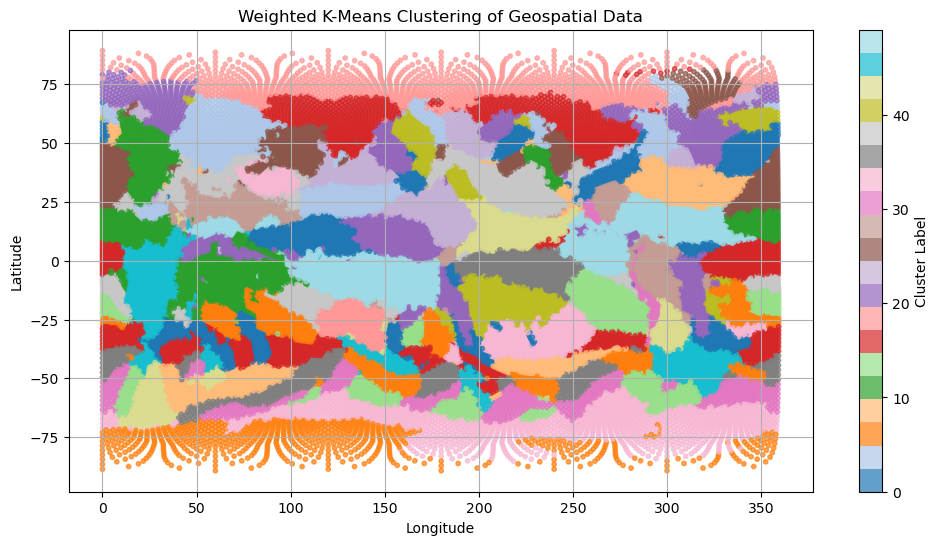

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# print(latent_mesh_nodes.shape)
print(latent_mesh_nodes.shape)

# 使用K-Means进行聚类
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(latent_mesh_nodes[:, 0, :])

# 可视化聚类结果
plt.figure(figsize=(12, 6))
sc = plt.scatter(_mesh_nodes_lon, _mesh_nodes_lat, c=labels, cmap='tab20', s=10, alpha=0.7)
plt.title('Weighted K-Means Clustering of Geospatial Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(sc, label='Cluster Label')
plt.grid(True)
plt.show()


# Prediction

(721, 1440)
[248.65813 248.66577 248.67087 ... 247.52356 247.54395 247.52101]


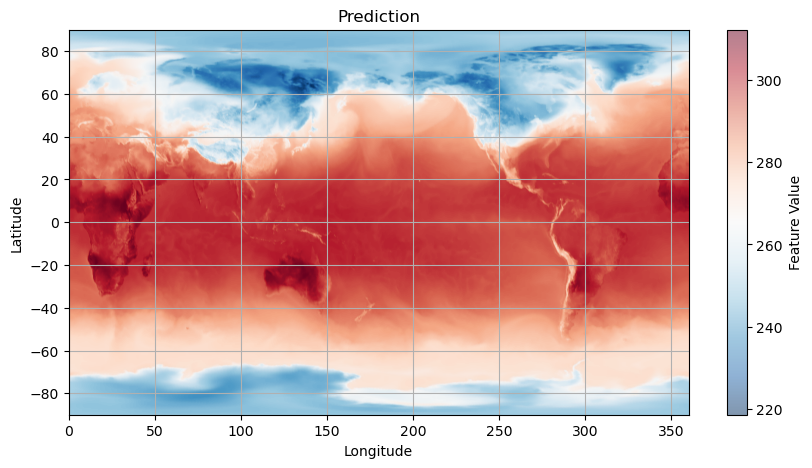

In [ ]:
# 
feature_to_plot = predictions["2m_temperature"].isel(time=0).isel(batch=0)

print((feature_to_plot.shape))
print((feature_to_plot.values.flatten()))

# 绘制散点图，并用颜色映射展示特征值
plt.figure(figsize=(10, 5))
sc = plt.scatter(x=flat_grid_lon, y=flat_grid_lat, c=feature_to_plot.values.T, cmap='RdBu_r', s=1, alpha=0.5)
plt.title('Prediction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([0, 360])
plt.ylim([-90, 90])
plt.colorbar(sc, label='Feature Value')
plt.grid(True)
plt.show()